# Student or AI generated essays. A classification problem

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, TransformerMixin
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.regularizers import l1_l2
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:

nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shoba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shoba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shoba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# os.chdir("/content/drive/MyDrive/Final_project/deep_learning_models/")

In [ ]:
# !pwd

/content/drive/MyDrive/Final_project/deep_learning_models


In [ ]:
df = pd.read_csv("E:/PGD-AI/Project_AI/training_customized_dataset_v6.csv")

In [ ]:
df= df.iloc[:,1:]

In [ ]:
df.head(5)

,text,generated
0,"Dear principal,\n\nI agree with policy number ...",0
1,Introduction\n\nHomework clubs have been a top...,1
2,The summer project should be Teacher-designed ...,0
3,I think that a summer project should really be...,0
4,A huge crowd gathered around me. Teens and you...,0


<Axes: xlabel='generated', ylabel='count'>

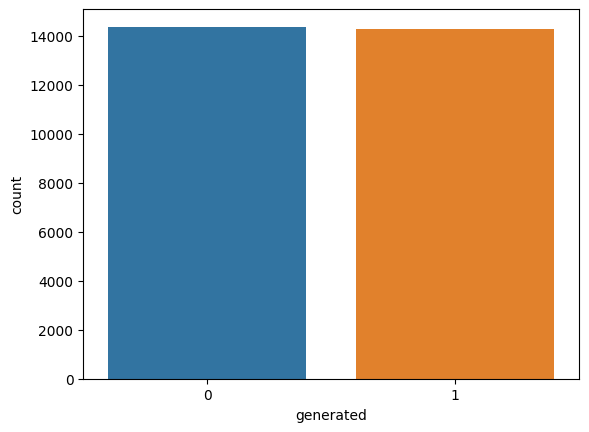

In [ ]:
import seaborn as sns
sns.countplot(x='generated', data=df)

In [ ]:
df["generated"].value_counts()

0    14375
1    14290
Name: generated, dtype: int64

In [ ]:
# get the number of sentences in each essay or letter
def number_sentence(para):
    sentence = sent_tokenize(para)
    return len(sentence)

In [ ]:
# ge the average number of words per sentences
def avg_words_per_sentence(paragraph):
  # tokenize the the essay into sentence
    sentences = sent_tokenize(paragraph)
    # aggregate number of words in each sentence
    word_count = sum(len(word_tokenize(sentence)) for sentence in sentences)
    # get the average number of words per sencence (sum of all words in each sentence in an essay/ number of sentences in an essay)
    if len(sentences) == 0:
        return 0
    return round(word_count / len(sentences),0)

In [ ]:
# apply the above number_sentence function
df["number_sentence"] = df["text"].apply(number_sentence)

In [ ]:
# apply the above avg_words_per_sentence function
df["avg_words"] = df["text"].apply(avg_words_per_sentence)

In [ ]:
df.head(5)

,text,generated
0,"Dear principal,\n\nI agree with policy number ...",0
1,Introduction\n\nHomework clubs have been a top...,1
2,The summer project should be Teacher-designed ...,0
3,I think that a summer project should really be...,0
4,A huge crowd gathered around me. Teens and you...,0


In [ ]:
a = [len(df["text"][i].split(" ")) for i in range(len(df["text"]))]

In [ ]:
sum(a)/len(a)

389.8294086865515

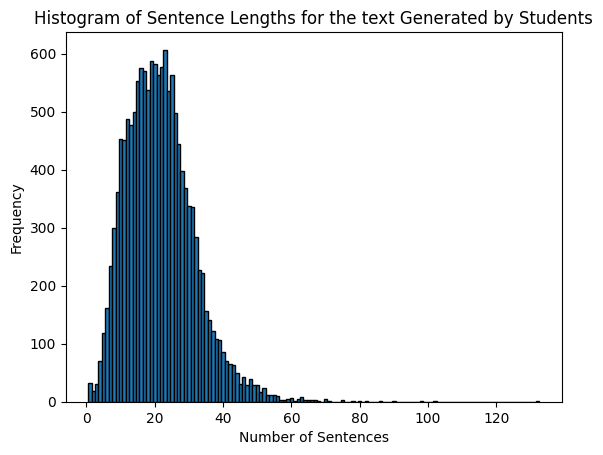

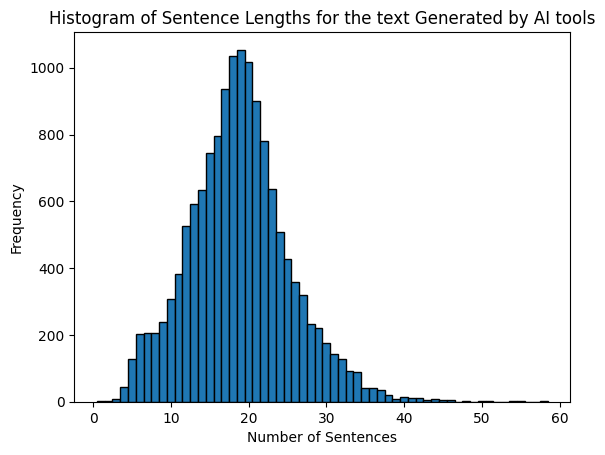

In [ ]:
for i in df["generated"].unique():
  df_1 = df[df["generated"]==i]

  plt.hist(df_1['number_sentence'], bins=range(min(df_1['number_sentence']), max(df_1['number_sentence']) + 1), align='left', edgecolor='black')
  plt.xlabel('Number of Sentences')
  plt.ylabel('Frequency')
  plt.title('Histogram of Sentence Lengths for the text Generated by {}'.format("Students" if i == 0 else "AI tools"))
  plt.show()

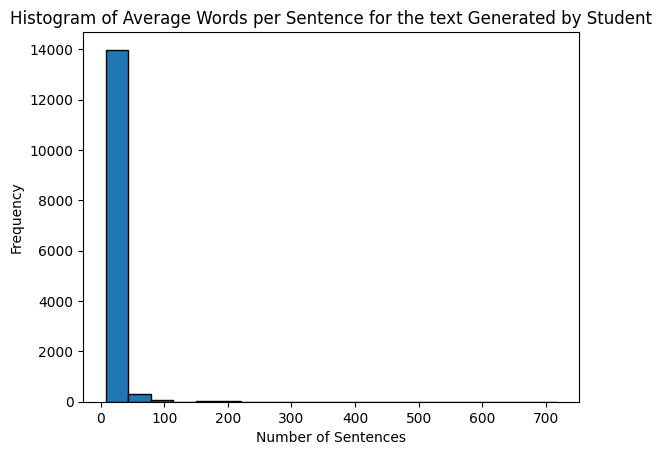

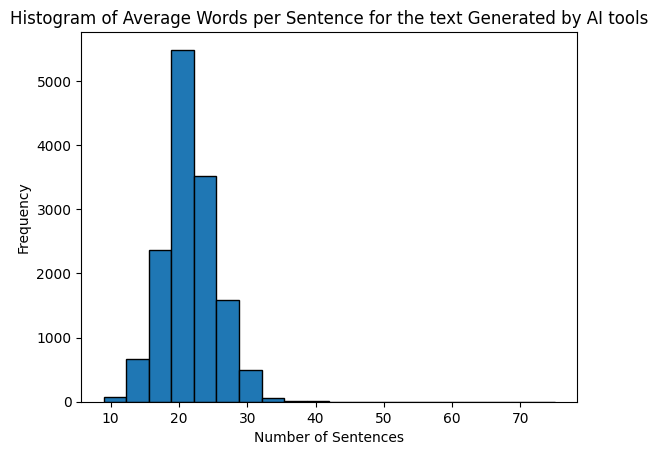

In [ ]:
for j in df["generated"].unique():
    df_1 = df[df["generated"]==j]

    plt.hist(df_1['avg_words'], bins=20, edgecolor='black')
    plt.xlabel('Number of Sentences')
    plt.ylabel('Frequency')
    plt.title('Histogram of Average Words per Sentence for the text Generated by {}'.format("Student" if j==0 else "AI tools"))
    plt.show()

In [ ]:
# df_1 = df.sample(frac=0.5)
df_1 = df.copy()

In [ ]:
df_1.shape

(28665, 2)

In [ ]:
df_1["generated"].value_counts()

0    14375
1    14290
Name: generated, dtype: int64

In [ ]:

corpus =df_1["text"]
y = df_1["generated"]

In [ ]:
type(corpus), type(y)

(pandas.core.series.Series, pandas.core.series.Series)

In [ ]:
# Split Data into Train, Validation, and Test
X_train, X_temp, y_train, y_temp = train_test_split(corpus, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=0)


In [ ]:
def clean_text(text):
  text_cleaned = []
  for text in text:
      clean_text = text.replace("\n\n", " ")
      clean_text = re.sub(r"[^a-zA-Z\s]", "", clean_text)
      clean_text = clean_text.lower()
      words = word_tokenize(clean_text)
      words = [word for word in words if word not in stop_words]
      words = [lemmatizer.lemmatize(word) for word in words]
      text_cleaned.append(" ".join(words))
  return text_cleaned

In [ ]:
X_train_cleaned = clean_text(X_train)

In [ ]:
text_length = [len(i.split(" ")) for i in X_train_cleaned]

In [ ]:
max(text_length), min(text_length), round(sum(text_length)/len(text_length),0)

(880, 4, 203.0)

In [ ]:
X_val_cleaned = clean_text(X_val)

## Tekenization (oov)

In [ ]:
# using tokenizer we can create word to index dictionary where each unique word in the corpus used as a key and it's unique index used as the value.
# num_words	- the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
# oov_token - 	if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls

word_tokenize = Tokenizer(num_words=20000,oov_token="<OOV>")
word_tokenize.fit_on_texts(X_train_cleaned)

X_train_cln_sequence = word_tokenize.texts_to_sequences(X_train_cleaned)
X_val_cln_sequence = word_tokenize.texts_to_sequences(X_val_cleaned)

In [ ]:
# The word_index attribute provides a dictionary of unique identifiers for each word in the corpus.
word_index = word_tokenize.word_index

In [ ]:
# word_index

{'<OOV>': 1,
 'student': 2,
 'car': 3,
 'people': 4,
 'would': 5,
 'school': 6,
 'electoral': 7,
 'vote': 8,
 'help': 9,
 'college': 10,
 'state': 11,
 'also': 12,
 'like': 13,
 'time': 14,
 'one': 15,
 'could': 16,
 'make': 17,
 'get': 18,
 'may': 19,
 'way': 20,
 'many': 21,
 'life': 22,
 'work': 23,
 'class': 24,
 'need': 25,
 'think': 26,
 'system': 27,
 'thing': 28,
 'take': 29,
 'even': 30,
 'teacher': 31,
 'good': 32,
 'phone': 33,
 'activity': 34,
 'usage': 35,
 'use': 36,
 'city': 37,
 'better': 38,
 'president': 39,
 'know': 40,
 'benefit': 41,
 'project': 42,
 'u': 43,
 'dont': 44,
 'popular': 45,
 'want': 46,
 'important': 47,
 'new': 48,
 'learning': 49,
 'day': 50,
 'reason': 51,
 'candidate': 52,
 'election': 53,
 'driving': 54,
 'go': 55,
 'example': 56,
 'community': 57,
 'able': 58,
 'learn': 59,
 'venus': 60,
 'believe': 61,
 'lead': 62,
 'world': 63,
 'limiting': 64,
 'person': 65,
 'face': 66,
 'conclusion': 67,
 'something': 68,
 'transportation': 69,
 'might': 70

In [ ]:
# Get dictionary of words by number of documents in which they appear
# word_docs = word_tokenize.word_docs

# sorted(word_docs.items())

[('aalong', 1),
 ('aalso', 1),
 ('aaron', 1),
 ('ab', 1),
 ('abad', 1),
 ('abandaining', 1),
 ('abandon', 4),
 ('abandoned', 2),
 ('abandoning', 4),
 ('abaondoon', 1),
 ('abaondooniong', 1),
 ('abbreviated', 1),
 ('abduction', 1),
 ('abe', 1),
 ('abel', 1),
 ('abesences', 1),
 ('abhor', 1),
 ('abide', 9),
 ('ability', 386),
 ('abiltiys', 1),
 ('abisurd', 1),
 ('abiurd', 1),
 ('abiut', 1),
 ('ablaze', 1),
 ('able', 1001),
 ('abled', 1),
 ('ablewant', 1),
 ('ablility', 1),
 ('ablitily', 1),
 ('ablity', 2),
 ('abloshied', 1),
 ('abnormal', 2),
 ('abnormally', 1),
 ('aboard', 12),
 ('aboliih', 1),
 ('aboliihed', 1),
 ('aboliihing', 1),
 ('aboliisehd', 1),
 ('aboliished', 1),
 ('abolish', 85),
 ('abolished', 78),
 ('abolishing', 101),
 ('abolishment', 2),
 ('abolition', 20),
 ('aboloishing', 1),
 ('aboout', 1),
 ('aboove', 1),
 ('abopliih', 1),
 ('abording', 1),
 ('aborting', 1),
 ('abot', 1),
 ('abou', 2),
 ('abouit', 1),
 ('abound', 1),
 ('abount', 1),
 ('abour', 1),
 ('abover', 1),
 ('ab

In [ ]:
# Get dictionary of words by frequency of appearance in corpus
# word_counts = word_tokenize.word_counts

# sorted(word_counts.items())

[('aaa', 1),
 ('aap', 1),
 ('aaron', 1),
 ('aau', 1),
 ('ab', 2),
 ('abandon', 1),
 ('abandoned', 3),
 ('abandoning', 3),
 ('abd', 1),
 ('abe', 1),
 ('abhor', 1),
 ('abide', 7),
 ('abides', 1),
 ('ability', 302),
 ('abill', 2),
 ('abitious', 1),
 ('able', 922),
 ('abloish', 1),
 ('abnormal', 5),
 ('aboard', 10),
 ('aboliihing', 1),
 ('abolish', 63),
 ('abolished', 55),
 ('abolishing', 75),
 ('abolishment', 3),
 ('abolition', 14),
 ('abolitionist', 1),
 ('abomination', 1),
 ('abouth', 1),
 ('aboutinstead', 1),
 ('abover', 1),
 ('abraham', 1),
 ('abroad', 3),
 ('abrupt', 1),
 ('absence', 29),
 ('absent', 11),
 ('absenteeism', 3),
 ('absolutally', 1),
 ('absolute', 6),
 ('absolutely', 19),
 ('absolutley', 1),
 ('absolutly', 1),
 ('absorb', 6),
 ('absorbed', 3),
 ('absorbing', 1),
 ('absorption', 1),
 ('absouletly', 1),
 ('abstention', 1),
 ('abstract', 2),
 ('abstruct', 1),
 ('absurd', 5),
 ('abundance', 5),
 ('abundant', 4),
 ('abundantly', 1),
 ('abuot', 1),
 ('abuse', 13),
 ('abused', 

In [ ]:
X_train_cln_token_pad_seq = pad_sequences(X_train_cln_sequence, maxlen=200, padding="post", truncating="post")

In [ ]:
X_val_cln_token_pad_seq = pad_sequences(X_val_cln_sequence, maxlen=200, padding="post", truncating="post")

In [ ]:
len(X_train_cln_token_pad_seq[0])

200

In [ ]:
X_train_cln_token_pad_seq[0]

array([  179,     6,  2147,  1162,  1885,   799,  3063,    22,  1232,
          18,  1314,  1148,    89,     6,  5189,  4285,    58,   719,
        1777,  1625,   346,   237,   829,   115,   116,    22,    14,
         719,  2599,  4612,   374,   313,   235,   185,   504,  3336,
         113,     1,   378,   341,   559,    66,    30,   412,   348,
         226,  1344,   313,  1591,  2234,  1963,  3112,  2914,   110,
        1049,   235,    14,  1625,   195,  1559,   160,  1618,   116,
        1397,  4286,   160,   341,    86, 11281,  1128,  2810,  2006,
         783,    11,   484,   374,   313,    71,   374,   313,  2411,
         405,    46,    66,  2243,    49,  6528,   484,   374,   313,
         978,   260,   593,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
# from tensorflow.keras.preprocessing.text import Tokenizer

# # Sample text data
# texts = ["This is a sample sentence.", "Another example sentence."]

# # Create a tokenizer
# tokenizer = Tokenizer()

# # Fit the tokenizer on the text data
# tokenizer.fit_on_texts(texts)


In [ ]:
# # Convert text to sequences of integers
# sequences = tokenizer.texts_to_sequences(texts)

# # Print the result
# print("Original texts:", texts)
# print("Sequences of integers:", sequences)
# these indecies are assigned based on the frequencies of the words, the word "sentence" has higher frequence it has the value of 1


Original texts: ['This is a sample sentence.', 'Another example sentence.']
Sequences of integers: [[2, 3, 4, 5, 1], [6, 7, 1]]


In [ ]:
# from gensim.models import KeyedVectors
# import gensim.downloader as api

# model_word2vec = api.load("word2vec-google-news-300")


In [ ]:
# len(model_word2vec["apple"])

300

In [ ]:
# type(model_word2vec)

In [ ]:
# model_word2vec.save("/content/drive/MyDrive/Final_project/deep_learning_models/model_word2vec.kv")

In [ ]:
from gensim.models import KeyedVectors

loaded_wv_model = KeyedVectors.load("model_word2vec.kv")

In [ ]:
len(loaded_wv_model["king"])

300

In [ ]:
# +1- If a word is encountered during testing that wasn't seen during training, it can be replaced with the OOV token
embedding_matrix = np.zeros((len(word_index)+1, 300))

In [ ]:
embedding_matrix.shape

(45630, 300)

In [ ]:
type(word_index)

dict

In [ ]:
for word, i in word_index.items():
  if word in loaded_wv_model:
    embedding_matrix[i] = loaded_wv_model[word]
  else:
    embedding_matrix[i] = np.zeros(300)


In [ ]:
embedding_matrix.shape

(45630, 300)

# Defining the LSTM Deep Learning Model, layers, and embeddings

In [ ]:
# Define the deep learning model
vec_size = len(embedding_matrix)  # Assuming vec_size should match the number of words in your vocabulary
embedding_vector_feature = embedding_matrix.shape[1]  # Assuming 300 based on your embedding_matrix shape
max_text_length = 200  # Assuming 200 as in your original code

optimizer = Adam(learning_rate=0.00001)
model = Sequential()
model.add(Embedding(vec_size, embedding_vector_feature, input_length=max_text_length, weights=[embedding_matrix]))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid", kernel_regularizer= l1_l2(l1=0.01, l2=0.01)))
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          13689000  
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 13759251 (52.49 MB)
Trainable params: 13759251 (52.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# pip install --upgrade tensorflow


In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


#Training the Model

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
type(X_train_cln_token_pad_seq), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [ ]:
history = model.fit(X_train_cln_token_pad_seq, y_train,validation_data=[X_val_cln_token_pad_seq,y_val],epochs=10, batch_size=64, callbacks=[early_stopping])

Epoch 1/10
269/269 [==============================] - 253s 852ms/step - loss: 0.8084 - accuracy: 0.5471 - val_loss: 0.8025 - val_accuracy: 0.5772
Epoch 2/10
269/269 [==============================] - 202s 752ms/step - loss: 0.7987 - accuracy: 0.5793 - val_loss: 0.7926 - val_accuracy: 0.5981
Epoch 3/10
269/269 [==============================] - 209s 779ms/step - loss: 0.7883 - accuracy: 0.6000 - val_loss: 0.7808 - val_accuracy: 0.6235
Epoch 4/10
269/269 [==============================] - 231s 859ms/step - loss: 0.7746 - accuracy: 0.6240 - val_loss: 0.7609 - val_accuracy: 0.6591
Epoch 5/10
269/269 [==============================] - 235s 875ms/step - loss: 0.7348 - accuracy: 0.6764 - val_loss: 0.6773 - val_accuracy: 0.7270
Epoch 6/10
269/269 [==============================] - 208s 773ms/step - loss: 0.6217 - accuracy: 0.7554 - val_loss: 0.5798 - val_accuracy: 0.7862
Epoch 7/10
269/269 [==============================] - 221s 821ms/step - loss: 0.5689 - accuracy: 0.8339 - val_loss: 0.5441 -

In [ ]:
# create plot to shows the results
def plot_metrics(history, metric, title, loc='lower right'):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.legend(loc=loc)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.title(title)
    plt.show()

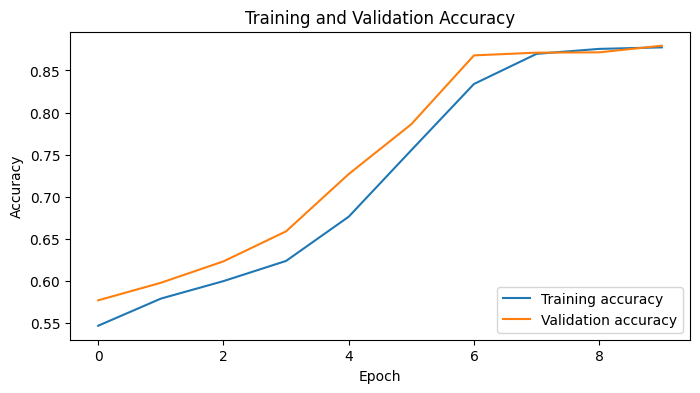

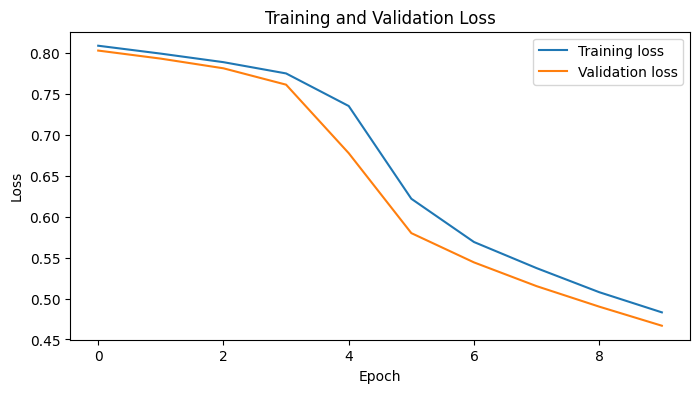

In [ ]:
# Plot accuracy
plot_metrics(history, 'accuracy', 'Training and Validation Accuracy')

# Plot loss
plot_metrics(history, 'loss', 'Training and Validation Loss', loc='upper right')

In [ ]:
X_test

7501     Limiting the usage of cars has personal and pr...
22226    The FACS\n\ncould be valuable or untrustworthy...
27571    In 2002, a study showed that only 23% of Ameri...
13152    I have always been fascinated with the fast-pa...
17431    I think you should join the program and become...
                               ...                        
4523     The face that you seem to see on Mars is just ...
22188    Dear Principal,\n\nI believe that requiring st...
8743      The idea of limiting car usage has been gaini...
9609     Dear Principal,\n\nI am writing this letter to...
23587    [Your Name]\n[Your Address]\n[City, State, ZIP...
Name: text, Length: 3440, dtype: object

In [ ]:
X_test_cleaned = clean_text(X_test)

In [ ]:
X_test_cln_sequence = word_tokenize.texts_to_sequences(X_test_cleaned)

In [ ]:
X_test_cln_token_pad_seq = pad_sequences(X_test_cln_sequence, maxlen=200, padding="post", truncating="post")

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_cln_token_pad_seq, y_test)

108/108 [==============================] - 25s 177ms/step - loss: 0.4646 - accuracy: 0.8837


In [ ]:
prediction = model.predict(X_test_cln_token_pad_seq)

108/108 [==============================] - 18s 138ms/step


In [ ]:
type(prediction)

numpy.ndarray

In [ ]:
prediction

array([[0.10731667],
       [0.29423615],
       [0.10161354],
       ...,
       [0.90755874],
       [0.30898017],
       [0.90990084]], dtype=float32)

In [ ]:
# X_test_data = pd.Series(X_test, name="X_test")
# y_test_data =pd.Series(y_test, name="y_test")


In [ ]:
prediction_data_ = [val for sublist in prediction for val in sublist]

In [ ]:
type(prediction_data_)

list

In [ ]:
type(X_test), type(y_test), type(prediction)

(pandas.core.series.Series, pandas.core.series.Series, numpy.ndarray)

In [ ]:
df_prediction = pd.DataFrame({"X_test":X_test,"y_test":y_test})

In [ ]:
df_prediction["prediction"] = prediction_data_

In [ ]:
df_prediction.tail(50)

,X_test,y_test,prediction
25956,In the midst of sprawling metropolises and con...,1,0.894006
26304,Whether summer projects for students should be...,1,0.822763
6323,"Dear Senator,\n\nI am writing to you today to ...",1,0.865887
26727,Doing small acts of kindness can have a signi...,1,0.289103
22169,I think\n\nI argee with this active because so...,0,0.283023
60,While distance learning provides greater flexi...,1,0.903648
9427,"As an eighth-grade student, it is important to...",1,0.893727
6948,"The Electoral College, a distinctive feature o...",1,0.882978
6644,"When the Viking 1 discovered the face on Mars,...",0,0.120487
25180,"Dear Senator,\n\nI am writing to you today to ...",1,0.778877


In [ ]:
prediction_ = (prediction > 0.5).astype(int)

In [ ]:
conf_matrix = confusion_matrix(y_test, prediction_)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1634   77]
 [ 323 1406]]


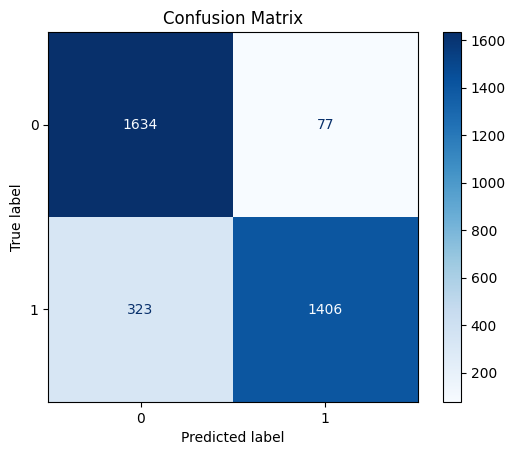

In [ ]:
# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])  # Specify the class labels
disp.plot(cmap='Blues')  # You can choose a different colormap if you prefer
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, prediction_))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1711
           1       0.95      0.81      0.88      1729

    accuracy                           0.88      3440
   macro avg       0.89      0.88      0.88      3440
weighted avg       0.89      0.88      0.88      3440



In [ ]:
# # After fitting the pipeline
# X_train_transformed = X_train.copy()

# # Manually transform each step
# for name, transformer in text_pipeline.named_steps.items():
#     if name != 'model':
#         X_train_transformed = transformer.transform(X_train_transformed)

# # Inspect the data types
# print(type(X_train_transformed))  # Check the data type of X_train_transformed
# print(type(y_train))              # Check the data type of y_train
